### Amazon Fine Food Reviews

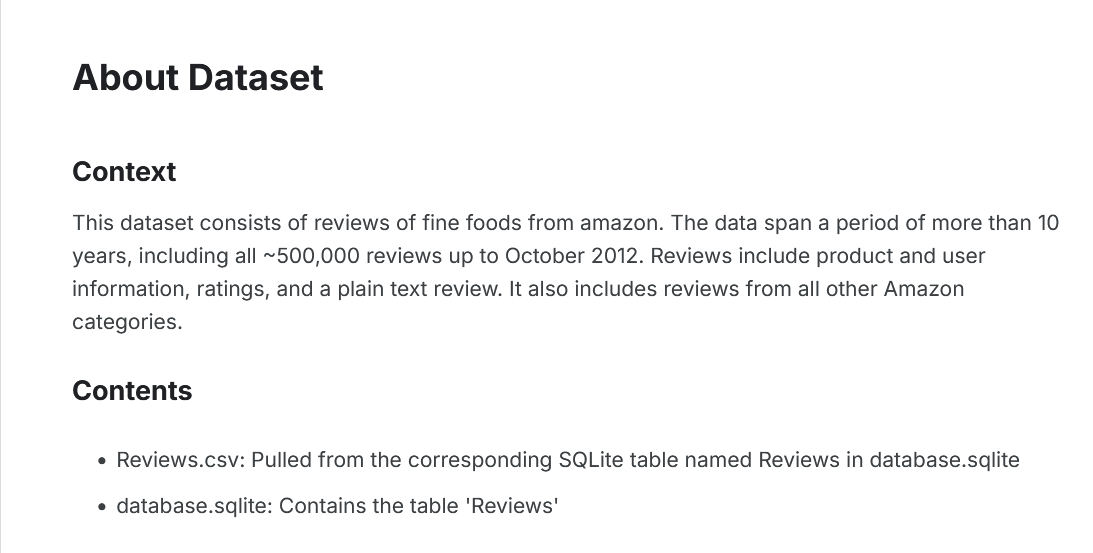
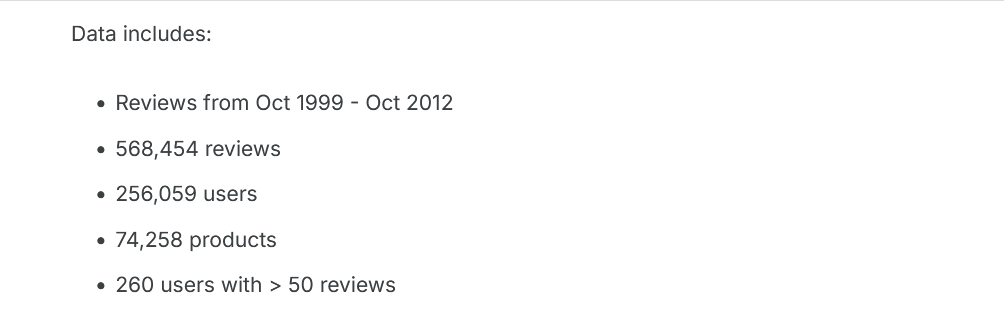

#### Import Basic Libraries

In [205]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import nltk
import string
import sqlite3
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report , roc_auc_score , roc_curve

#### After importing basic libraries we need to import some NLP libraries

In [11]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer     #reduce word in root word
from sklearn.feature_extraction.text import TfidfVectorizer    #word to vector

#### Now we import the data but data is not in csv format its sql format so we nned to make coonection with sql database and then we will fire qeury and extract the data from table . table name is Reviews in database and name of database is 'database.sqlite'

In [27]:
conn = sqlite3.connect('E://NLP_Lecture_Notes_Learnbay_Sundaram_sir//Day_8_11th_July//database.sqlite~//database.sqlite')   # name of database(inisde of it table contains)

#### sqlite3 is the Python interface to interact with an SQLite database.

##### database.sqlite is database in my local system

In [28]:
conn

#### These establish relation between database and python

#### Now we will fire query by python with help of connection to extract the data from database table(Reviews)

In [29]:
query = "select name from sqlite_master where type = 'table' "

In [31]:
table = pd.read_sql_query(query , conn)

In [33]:
table 

,name
0,Reviews


#### We have 1 table in database called Reviews

#### Now we read data from table by pd.read_sql_query

In [41]:
query = 'select * from Reviews where Score != 3 limit 5000'

#### Here we write query for to extract data from sql table where we want 5000 data and we don't want Score !=3 means we don't want neutral review. I want only positive and negative review score . because score is nothing but how much give score to that food ptoduct out of 5 so generally we take 1-2 is negative and 4-5 is positive and 3 is neutral and we want only 5000 records so we use limit(mysql) . if we use SQL server then we will use TOP(keyword)

In [45]:
df = pd.read_sql_query(query , conn)

In [47]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [48]:
df.shape

(5000, 10)

##### Insights : We have 5000 records and 10 features along with target column

#### Info

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      5000 non-null   int64 
 1   ProductId               5000 non-null   object
 2   UserId                  5000 non-null   object
 3   ProfileName             5000 non-null   object
 4   HelpfulnessNumerator    5000 non-null   int64 
 5   HelpfulnessDenominator  5000 non-null   int64 
 6   Score                   5000 non-null   int64 
 7   Time                    5000 non-null   int64 
 8   Summary                 5000 non-null   object
 9   Text                    5000 non-null   object
dtypes: int64(5), object(5)
memory usage: 390.8+ KB


##### Here we have to make sentiment analysis on text data (text column) whether that review is positive or negative

#### And score is target column which contains score of food review . It is target column

### Data Preprocessing

#### 1.Handling the missing values

In [50]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

#### Insights : Fine . There is no any missing values into data

#### We making convert our target variable into required format on basis of threshold values . For practice purpose we considering 1-2 as negative sentiments i.e. 0  and 4-5 as positive sentiments i.e. 1.but in real time scenario we will take decsision based on case study as well by help of SME (Subject Matter Expert)

In [51]:
df['Score'].value_counts()

5    3420
4     767
1     504
2     309
Name: Score, dtype: int64

#### Here we consider first 5000 records so we check in first 5000 records contains all count values are getting or not but here we getting all value counts data.

##### We creating one function for it

In [53]:
def threshold(score):
    
    if score <= 2:
        
        return 0
    else:
        
        return 1

In [ ]:
df['Score'] = df['Score'].apply(threshold)   #apply is function which takes another function as 
                                          #an argument and perform for loop implicitely on data

In [57]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


#### value counts of score target variable after the numeric one

In [58]:
df['Score'].value_counts()

1    4187
0     813
Name: Score, dtype: int64

##### Insights : Data is Imbalance

#### Check Duplication of records

In [62]:
df.duplicated().sum()

0

#### Inisghts : No duplication of data 

#### Now we have two columns HelpfulnessNumerator and HelpfulnessDenomenator

#### Basically HelpfulnessNumerator told the no of customers or count of customers who clicked this review is helpful 
#### HelpfulnessDenomenator told the no of customers or count of customers who clicked any helpful and not helpful i.e.HelpfulnessNumerator is the total votes(by user)

##### HelpfulnessNumerator is the part of total votes means HelpfulnessNumerator is subset of Helpfulness denomenator

##### so basically ratio of this two is told how much percentage of votes for this review helpful
##### eg : numerator = 1 and denomenator = 2 then ratio is 1/2 i.e. this review is  consider as helpful by 50 % those who voted  (means 50% this review is helpful)

##### So HelpfulnessNumerator is the less than or equals to Helpfulnessdenomenator . HelpfulnessNumerator is should not be exceed than Helpfulnessdenomenator

Yes, you are absolutely correct! Your explanation of the helpfulness calculation is spot on. Let me break it down for clarity:

### Review 1 (1 helpful vote, 0 not helpful votes):
- **Numerator (helpful votes)** = 1 (1 user found the review helpful)
- **Denominator (total votes)** = 1 (total votes = helpful + not helpful = 1 + 0)
- **Helpfulness ratio** = \( \frac{1}{1} = 100\% \)

This means the review is considered **100% helpful** since all the voters found it helpful.

---

### Review 2 (1 helpful vote, 1 not helpful vote):
- **Numerator (helpful votes)** = 1 (1 user found the review helpful)
- **Denominator (total votes)** = 2 (total votes = helpful + not helpful = 1 + 1)
- **Helpfulness ratio** = \( \frac{1}{2} = 50\% \)

This means the review is considered **50% helpful**, as half of the voters found it helpful and the other half did not.

---

### Review 3 (3 helpful votes, 0 not helpful votes):
- **Numerator (helpful votes)** = 3 (3 users found the review helpful)
- **Denominator (total votes)** = 3 (total votes = helpful + not helpful = 3 + 0)
- **Helpfulness ratio** = \( \frac{3}{3} = 100\% \)

This means the review is considered **100% helpful**, as all the voters found it helpful.

---

### Key Point:
As you correctly pointed out, the **numerator (helpful votes)** is **always less than or equal to the denominator (total votes)** because:
- The numerator represents the helpful votes.
- The denominator represents the total number of votes, which includes both helpful and not helpful votes.
  
Thus, **numerator ≤ denominator** is always true.

Your understanding is absolutely correct! The helpfulness ratio reflects the proportion of helpful votes among all votes, and it will always be a value between 0% (no helpful votes) and 100% (all helpful votes).

#### Here we will check we all rows contains HelpfulnessNumerator is should less than equal to  HelpfulnessDenominator(because some time by mistake of data entry it violetes the rule) or we will take only those records which satisfy this HelpfulnessNumerator is should less than equal to  HelpfulnessDenominator condition from dataframe

In [79]:
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]

In [80]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [81]:
df.shape

(5000, 10)

##### Insights : Fine , we don't have any record which violets that rule . we get same shape that already we had same shape

### Now our data is ready for preprocessing

#### We randomly check how our text data is look like

In [102]:
sentence_0 = df['Text'].values[0]
print(sentence_0)


print('-----'*20)

sentence_200 = df['Text'].values[200]
print(sentence_200)

print('-----'*20)

sentence_1000 = df['Text'].values[1000]
print(sentence_1000)


print('-----'*20)

sentence_3000 = df['Text'].values[3000]
print(sentence_3000)

print('-----'*20)

sentence_4000 = df['Text'].values[4000]
print(sentence_4000)


print('-----'*20)

sentence_4999 = df['Text'].values[4999]
print(sentence_4999)


I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
----------------------------------------------------------------------------------------------------
I love strong, full bodied quality tea and typically drink assam, irish breakfast or early grey tea, but as the other reviewer noted the price per pound can be discouraging. So I have been searching for a quality full bodied tea that wasn't bitter at a more palatable price point, and this certainly fits the bill. And unlike some other teas where they tend to be better in one form or another, i.e. iced vs. hot, this tea is excellent in both forms. I would certainly recommend this to anyone who prefers that smooth full bodied quality tea that doesn't cost an arm and leg.
-----------------------------------------------------------

#### Insights : The reason is why check data randomly , we want to knowwhat type of data is there in text means any ambiguity data like numers or special characters and we noticed there are some html brackets are there (<br /><br />) and some numerical values are also in text data

#### Here end of the day we will make word to vec by feature extraction method like N gram and TFIDF so while creating features we will avoid the stopwords(most frequent words)

#### so we collect some stopwords from previous spacy model and collect some from corpus.words(stopwords)

In [103]:
stopwords = set(['see', 'his', 'therefore', 'yourself', 'everyone', 'whoever', 'now', 'would', 'sometimes', 'indeed', 'once', '’s', 'several', 'behind', 'were', 'various', 'ten', 'do', 'already', 'most', 'used', 'anyhow', 'or', 'many', 'but', 'these', 'in', 'which', 'sixty', 'myself', 'than', 'same', 'along', 'serious', 'something', 'show', 'he', 'within', 'latterly', 'hers', 'somehow', 'moreover', 'doing', 'whereas', 'none', 'last', 'somewhere', 're', 'however', 'much', 'at', 'any', 'out', '’d', 'yours', 'nobody', 'via', 'never', 'without', 'another', 'here', 'empty', 'have', 'before', 'well', 'latter', 'seeming', 'if', 'into', 'the', 'amongst', 'front', 'someone', 'except', 'either', 'namely', '‘m', 'just', 'my', 'why', 'per', 'ours', 'move', 'unless', 'some', 'me', 'can', "'ve", 'an', 'down', 'every', 'each', 'only', 'hereupon', 'nevertheless', 'enough', 'less', 'am', 'from', 'up', 'own', 'seemed', 'for', 'with', 'thru', 'onto', 'then', 'sometime', 'everywhere', 'during', 'perhaps', 'our', 'therein', 'did', 'across', 'mostly', 'we', 'neither', 'give', 'themselves', 'as', 'whereby', 'where', 'please', 'your', 'next', 'third', 'five', 'both', 'this', 'its', 'further', 'you', 'because', 'whatever', 'keep', 'few', 'even', "'s", 'three', 'through', 'yet', 'over', 'meanwhile', 'also', 'there', 'though', 'although', 'while', 'wherein', 'one', 'quite', 'part', 'those', 'anyway', 'four', 'i', 'really', 'whence', 'has', 'n’t', 'might', 'towards', 'below', 'herein', 'forty', 'whereupon', '‘re', 'after', 'toward', 'will', 'together', 'around', 'on', 'twenty', 'when', 'above', 'what', 'was', '’ve', 'still', 'whom', 'hereafter', '’re', 'regarding', 'became', 'get', 'thereafter', 'yourselves', 'us', "'ll", 'done', 'anywhere', 'anything', "'d", 'made', 'be', 'thereby', 'very', 'nothing', 'mine', 'whose', 'say', 'top', 'among', 'of', 'ca', 'anyone', 'always', 'she', 'does', 'rather', 'afterwards', 'whenever', 'off', 'nowhere', 'formerly', 'become', 'they', 'fifty', 'go', 'must', 'whither', "'re", 'upon', 'often', 'becoming', 'seems', 'may', '’m', 'nine', 'is', 'noone', 'back', 'name', 'that', 'fifteen', 'so', 'under', 'her', 'hundred', 'others', 'almost', 'twelve', 'are', 'becomes', 'more', "'m", 'about', 'had', 'hence', 'make', 'not', 'beside', 'otherwise', 'seem', 'by', 'alone', 'it', "n't", 'their', 'a', 'him', '’ll', 'due', 'amount', 'again', 'eleven', 'wherever', 'whereafter', 'call', 'itself', 'beforehand', 'how', 'all', 'himself', 'being', 'against', 'throughout', 'two', 'could', 'thence', 'since', 'elsewhere', 'beyond', 'bottom', 'to', 'no', 'using', 'who', 'whether', '‘ve', 'else', 'such', 'thereupon', 'first', 'ourselves', 'herself', 'too', 'other', '‘ll', 'nor', '‘s', 'everything', 'least', 'ever', 'six', 'n‘t', 'between', 'side', 'take', 'until', '‘d', 'thus', 'them', 'full', 'been', 'eight', 'hereby', 'put', 'and', 'should', 'former', 'cannot', 'whole', 'besides','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

In [104]:
print(stopwords)

{'can', 'ma', 'during', 'six', 'upon', 'never', "you'll", 'four', 'until', 'eight', 'throughout', 'together', 'hasn', 'which', '’s', 'side', 'we', 'full', 'beforehand', 'whom', 'through', 'its', 'didn', 'due', 'us', 'neither', "needn't", 'for', 'whoever', 'whole', 'give', 'when', 'haven', 'were', 'may', 'anyway', 'over', 'yet', 'at', "'ve", 'into', 'everything', 'none', "it's", 'least', 'whence', 'it', 'sometime', 'per', 'anyone', 'sixty', 'seeming', 'call', "shouldn't", 'else', "'re", "she's", '‘d', 'this', 'anywhere', 'always', 'moreover', 'top', 'across', 'themselves', 'another', 'still', "you'd", 'ten', 'except', 'every', 'having', 'nor', 'then', 'ain', "isn't", 'within', 'they', 'mostly', 'everywhere', 'further', 'wherever', "n't", 'really', 'he', 'already', 'y', "'s", 'won', '‘s', 'hereupon', "couldn't", "wasn't", 'also', 'been', 'regarding', 's', 'indeed', 'does', 'therefore', 'while', 'sometimes', 'an', 'off', 'all', "don't", 'next', 'a', 'eleven', 'well', "aren't", 'meanwhile'

#### For processing text data we need some packages 

In [108]:
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

#### tqdm is python library which shows progress bar while runing loops or tasks. basically it show how much data get progressed or processed while  it perform

#### BeautifulSoup is python class which is use to parse html or xml data

#### Now here we clean our data

In [134]:
processed_review = []

for sentence in tqdm(df['Text'].values):
    
    sentence_without_https = re.sub(pattern = r'http\S+' , repl =  '' , string = sentence)
    #Here we substitute data which start with http and along with it or followed by one or more
    #non white space characters(exlcude /n,/t,spaces)
    
    sentence_without_html = BeautifulSoup(sentence_without_https , features = 'lxml').get_text()
    # lxml is parsing library in python . which is basically parsing HTL content.means it remove
    # html tags or html content
    
    sentence_without_numbers_and_spacial_characters = re.sub(pattern = r"[^A-Za-z]+" , repl = ' '  , string = sentence_without_html)
    
    # this code replace everything except characters(A-Za-z)
    
    clean_sentence = ' '.join([token.lower() for token in sentence_without_numbers_and_spacial_characters.split() if token.lower() not in stopwords])
    # In this code basically we make split the entire sentence on spacees means we perform
    # tokenization here means each word get seperated and means iteration by iteration one
    # word get extracted  and we make that word into lowercase because we want to check our
    #tokens(features) with stopwords is it present in stopwords I don;t want to then
    # so stopwords are actually in lowercase so we will make to same for comparing because python
    # is case sensitive language so if difference between comparing things then result will get 
    #different. so then we will return lowrcase only then basically it is return as list means 
    # entire sentence so we convert list into string(sentence) by join
    
    processed_review.append(clean_sentence)
    #just append in empty list as one sentence per iteration
    
    

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2146.84it/s]


#### Now data looks like

In [135]:
sentence_0 = processed_review[0]
print(sentence_0)


print('-----'*20)

sentence_200 = processed_review[200]
print(sentence_200)

print('-----'*20)

sentence_1000 = processed_review[1000]
print(sentence_1000)


print('-----'*20)

sentence_3000 = processed_review[3000]
print(sentence_3000)

print('-----'*20)

sentence_4000 = processed_review[4000]
print(sentence_4000)


print('-----'*20)

sentence_4999 = processed_review[4999]
print(sentence_4999)

bought vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
----------------------------------------------------------------------------------------------------
love strong bodied quality tea typically drink assam irish breakfast early grey tea reviewer noted price pound discouraging searching quality bodied tea bitter palatable price point certainly fits bill unlike teas tend better form e iced vs hot tea excellent forms certainly recommend prefers smooth bodied quality tea cost arm leg
----------------------------------------------------------------------------------------------------
gatorade g way want benefits gatorade sugar pre diabetes state days drinking type gatorade instead regular gatorade noticeably sugar good thing replenishes carbs electrolytes exercise putting unnecessary extra sugar system g comes flavors including fruit punch grape advantage bottles gatorade bottles smaller

#### We noticed all https , HTML content and numerical as well as special characters are get remove

### Now our data is ready for making word to vec means extraction fo features

In [168]:
tfidf_vector = TfidfVectorizer(ngram_range = (1 , 2) ,min_df = 10)
#### Here we give ngram_range (1,2) means here we create the features on basis of 1 word as well 
#### as two consecutive word (pair of words)

##### min_df means the word is should be at least appear that no of times(which mentioned into min_df) document eg :  min_df = 10 means , the word should be in at least 10 documents


##### max_df means the word is should be at most appear that no of times(which mentioned into max_df) document eg :  max_df = 40 means , the word  should be in at most 40 documents

In [169]:
tfidf_vector

TfidfVectorizer(min_df=10, ngram_range=(1, 2))

#### Fit the data(give that data which we want to make numeric) to tfidfvector

In [170]:
tfidf_vector.fit(processed_review)

TfidfVectorizer(min_df=10, ngram_range=(1, 2))

#### Here we just fit the data basically fit means its generate features from text(processed_review) on basis of ngram_range 

#### Here we want to know how features get create so thats why intentionally we fit the data only(not transform till now)

In [171]:
print('100 Features name randomly :----->\n\n\n' , tfidf_vector.get_feature_names_out()[1500:1600])

100 Features name randomly :----->


 ['met' 'metal' 'mg' 'mic' 'microphone' 'microwave' 'mics' 'mid' 'middle'
 'mild' 'miles' 'milk' 'milk chocolate' 'mill' 'mind' 'minerals' 'mini'
 'mint' 'minute' 'minutes' 'misleading' 'miss' 'missed' 'missing'
 'mistake' 'mix' 'mix makes' 'mix pancakes' 'mixed' 'mixes' 'mixing'
 'mixture' 'moderate' 'modified' 'moist' 'molasses' 'mom' 'money' 'month'
 'month old' 'monthly' 'months' 'months ago' 'morning' 'mornings' 'mother'
 'mountain' 'mouth' 'moved' 'movie' 'moving' 'mrs' 'msg' 'muffin'
 'muffin mix' 'muffins' 'mug' 'multiple' 'mushy' 'mustard' 'nasty'
 'natural' 'natural ingredients' 'naturally' 'nature' 'nd' 'near' 'nearby'
 'nearly' 'nectar' 'need' 'needed' 'needless' 'needs' 'negative' 'new'
 'new food' 'new york' 'newman' 'newman dog' 'newmans' 'nice'
 'nice flavor' 'nicely' 'night' 'noise' 'non' 'noodles' 'normal'
 'normally' 'nose' 'note' 'noted' 'notice' 'noticed' 'number' 'numerous'
 'nut' 'nutrients' 'nutrition']


##### We noticed there are some features are on single word and some features on pair of words because of we create ngram_range = (1,2) 

#### Now we transform the review :
###### Basically transform the review means transform make text(processed_review) in numbers

In [172]:
tfidf_vector_sparse_matrics = tfidf_vector.transform(processed_review)

In [173]:
tfidf_vector_sparse_matrics

<5000x2671 sparse matrix of type '<class 'numpy.float64'>'
	with 121333 stored elements in Compressed Sparse Row format>

#### Check data type we are lready know but we will check for best practice

In [174]:
print('Data type of tfidf_vector metrics is :' , type(tfidf_vector_sparse_matrics))
print('Shape of tfidf_vector is :' , tfidf_vector_sparse_matrics.get_shape())
print('How many features get create on 5000 records :' , tfidf_vector_sparse_matrics.get_shape()[1])

Data type of tfidf_vector metrics is : <class 'scipy.sparse._csr.csr_matrix'>
Shape of tfidf_vector is : (5000, 2671)
How many features get create on 5000 records : 2671


#### It create 124892 features on 5000 records without min_df or max_df(without hyperparametertuning)

#### It create 2671 features on 5000 records with min_df or max_df(with hyperparametertuning)

##### We can't handle 124892 features in machine learning . In deep learning it can be handle but not in ML so we reduce the features by min_df

##### Now we make sparse matrix it in array

In [177]:
x = pd.DataFrame(tfidf_vector_sparse_matrics.toarray())

In [178]:
x.shape

(5000, 2671)

#### Inisghts : From one text feature we get 2671 features by TFIDF

In [181]:
y = df['Score']

In [182]:
y.shape

(5000,)

#### Here we will split into train and test

In [186]:
x_train , x_test , y_train , y_test = train_test_split(x ,y , test_size = 0.25 , random_state = 2 , stratify = y)

In [187]:
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(3750, 2671) (1250, 2671) (3750,) (1250,)


##### Here our main aim is to implemented TFIDF so we make this as high priority so we will not make Data Balance but we don't have issue we make it as stratify = y so its not create probelm it will read another class also

### We build XGBOOST

In [193]:
xgb = XGBClassifier()

In [194]:
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Train the model

In [195]:
xgb.fit(x_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

##### Performance of model

In [210]:
y_train_pred_xgb = xgb.predict(x_train)
print(y_train_pred_xgb)
training_accuracy = accuracy_score(y_train , y_train_pred_xgb)
print('Training Accuracy is :' , training_accuracy)


y_test_pred_xgb = xgb.predict(x_test)
testing_accuracy = accuracy_score(y_test , y_test_pred_xgb)
print('Testing Accuracy is :' , testing_accuracy)


print('Classification Report of training accuracy')
print(classification_report(y_train , y_train_pred_xgb))


print('Classification Report of testing accuracy')
print(classification_report(y_test , y_test_pred_xgb))


[1 1 1 ... 0 0 1]
Training Accuracy is : 0.9789333333333333
Testing Accuracy is : 0.8808
Classification Report of training accuracy
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       610
           1       0.98      1.00      0.99      3140

    accuracy                           0.98      3750
   macro avg       0.99      0.94      0.96      3750
weighted avg       0.98      0.98      0.98      3750

Classification Report of testing accuracy
              precision    recall  f1-score   support

           0       0.78      0.37      0.50       203
           1       0.89      0.98      0.93      1047

    accuracy                           0.88      1250
   macro avg       0.84      0.67      0.72      1250
weighted avg       0.87      0.88      0.86      1250



#### Macro avg is not good. it get more than 10 diffrence between train and test(macro avg) i.e.model is get overfitted(More than 10% difference in train and test macro avg) . we can try another algorithm for this case study